In [1]:
import pandas as pd
from sklearn.feature_selection import f_classif, mutual_info_classif
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from IPython.display import Image
import json
from myds import enrichr_func
import tese_func
from sklearn.metrics import recall_score, precision_score, make_scorer
from sklearn.feature_selection import RFE, RFECV
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
from scipy import stats
import tese_func
from sklearn.feature_selection import mutual_info_classif, f_classif, chi2
import heapq
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import recall_score, precision_score, make_scorer
from functools import partial
from tqdm import tqdm
import time
from collections import defaultdict
from scipy.stats import spearmanr, pearsonr
from scipy.cluster import hierarchy
import random
from matplotlib_venn import venn3_unweighted

from collections import Counter

leg_size=16
title_size=16
axis_size = 18
alpha=0.6
dpi = 300
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [2]:
id="id"
data = pd.read_csv("data/data_ipet.csv").set_index(id)
target = "ipet2"

reps = {"I A": 1, "I B":2, "II A":3, "II B":4, "III A":5, "III B":6, "IV A":7, "IV B":8}
selgenes = ["CXCL2", "CXCL3", "CCL18", "TREM1", "SAA1", "PLAU", "FN1",
            "SPP1", "ITGA5", "CD9", "LRP1", "THBS1", "VEGFA"]
palette = ["#4E89AE", "#43658B", "#ED6663", "#FFA372"]
clinic_var = ["gender", "age","stage", "lmr>2.1"]


data["stage"] = data["stage"].replace(reps)

print(data.shape)
data.head()

(103, 770)


,A2M,ABCB1,ABCF1,ABL1,ADA,ADORA2A,AGK,AICDA,AIRE,AKT3,...,ZC3H14,ZKSCAN5,ZNF143,ZNF205,ZNF346,gender,age,stage,lmr>2.1,ipet2
id,,,,,,,,,,,,,,,,,,,,,
GSM3860476,10.61,7.83,10.09,8.34,8.48,8.90,7.30,0.36,6.44,10.34,...,8.93,5.38,7.88,3.59,7.15,0,18,3,1,0
GSM3860477,11.14,11.88,1.70,10.60,10.58,11.45,10.90,1.70,11.42,11.34,...,10.27,8.77,1.70,1.70,10.75,1,51,3,1,0
GSM3860478,9.91,9.94,9.04,8.60,9.67,9.56,9.51,0.16,9.43,10.86,...,9.51,7.68,7.58,2.63,8.62,1,38,3,0,0
GSM3860479,11.89,8.56,9.99,8.47,9.54,8.61,8.10,1.35,6.68,10.46,...,9.69,6.36,8.91,1.35,8.25,0,50,8,0,0
GSM3860480,9.69,7.15,9.27,8.29,8.39,8.14,7.17,0.66,5.43,10.42,...,9.40,5.72,7.79,5.07,7.43,1,22,3,1,0


In [3]:
data_union = pd.read_csv("data/dataset_union1.csv").set_index(id)
data_union.head()

,MAP4K2,HLA-E,ELANE,TNFSF13,DHX16,ICOSLG,LY86,MAP3K1,PSMB10,RIPK2,...,GNLY,C3,JAK3,GZMM,VEGFA,CD40LG,XCR1,RUNX1,MERTK,ipet2
id,,,,,,,,,,,,,,,,,,,,,
GSM3860476,9.07,13.86,0.36,10.04,8.72,8.18,7.42,9.41,11.65,7.85,...,8.26,10.09,12.20,9.83,8.48,8.19,7.51,9.89,8.31,0
GSM3860477,3.61,10.41,1.70,12.14,1.70,10.79,10.06,1.70,11.03,8.99,...,11.18,8.11,3.61,10.80,8.71,9.60,11.06,1.70,1.70,0
GSM3860478,9.14,12.96,0.16,10.40,8.42,9.45,9.35,9.13,11.11,8.73,...,8.68,9.78,11.74,10.03,8.82,8.97,8.96,8.71,6.75,0
GSM3860479,8.62,13.92,1.35,8.96,8.49,8.69,8.35,10.35,11.66,8.61,...,7.71,10.54,11.94,10.66,8.89,9.35,7.92,9.51,9.42,0
GSM3860480,9.10,13.36,0.66,9.90,8.71,7.99,5.63,9.02,10.85,7.67,...,8.41,9.20,11.88,8.61,10.73,7.15,5.38,10.35,8.58,0


## 1 Feature Selection

In [4]:
for cat in ["stage", "lmr>2.1", "age", "gender"]:
    print(cat in data_union.columns)

True
True
False
False


In [5]:
selgenes = ["CXCL2", "CXCL3", "CCL18", "TREM1", "SAA1", "PLAU", "FN1",
            "SPP1", "ITGA5", "CD9", "LRP1", "THBS1", "VEGFA"]
for s in selgenes:
    print(f"{s} - {s in data_union.columns}")

CXCL2 - True
CXCL3 - True
CCL18 - False
TREM1 - False
SAA1 - True
PLAU - False
FN1 - True
SPP1 - False
ITGA5 - True
CD9 - True
LRP1 - True
THBS1 - True
VEGFA - True


In [6]:
volc = pd.read_csv("volcano.csv")
lfc_thr = 1
pv_thr = 0.05
volc.loc[volc["pvalue"] == 0, 'pvalue'] = 0.0001
diff_reg = volc[ (abs(volc["log2FoldChange"])>lfc_thr) & (volc["pvalue"]<pv_thr) ]

###############################################################################################

selgenes = ["CXCL2", "CXCL3", "CCL18", "TREM1", "SAA1", "PLAU", "FN1",
            "SPP1", "ITGA5", "CD9", "LRP1", "THBS1", "VEGFA"]

union1, inter1, _, _ = tese_func.feat_select_miwi(threshold=0.1, prev_sel=selgenes)

#remover vars clinicas
union1_g = [x for x in union1 if x not in clinic_var]
inter1_g = [x for x in inter1 if x not in clinic_var]
print("-"*80)
print("Intersection of FC and intersection MIWI1: ",list( set(diff_reg["gene_symbol"]) & set(inter1_g) ))
print("Intersection of FC and union MIWI1: ", len(list( set(diff_reg["gene_symbol"]) & set(union1_g) )))

Features mi with p-value <= 0.1: 155
Features wi with p-value <= 0.1: 132

Union of features from MI and Wilcoxon has len: 250 
Intersection of features from MI and Wilcoxon has len: 37 

Previously selected in union: ['CXCL2', 'CXCL3', 'ITGA5', 'THBS1', 'SAA1', 'FN1', 'LRP1', 'CD9', 'VEGFA']
Previously selected in intersection: []
--------------------------------------------------------------------------------
Intersection of FC and intersection MIWI1:  ['FLT3', 'FCER2', 'CR2', 'ATM']
Intersection of FC and union MIWI1:  34


36


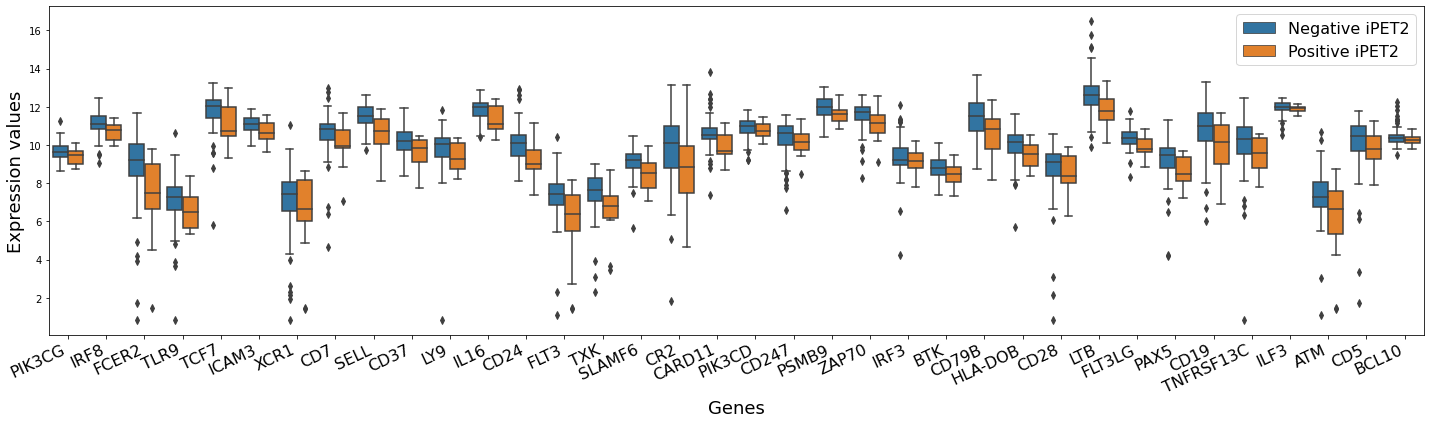

In [10]:
box = pd.DataFrame(columns=["values", "feature", "target"])

inter_gene = inter1_g
print(len(inter_gene))
for a in inter_gene:
    temp = pd.DataFrame()
    temp["values"] = data[a]
    temp["feature"] = a
    temp["target"] = data[target]
    box = box.append(temp)
    
box["target"] = box["target"].replace({0: "Negative iPET2", 1:"Positive iPET2"})

fig, ax = plt.subplots(1,1, figsize=(20,6))
sns.boxplot(x="feature", y="values", hue="target", data=box, ax=ax)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, fontsize=leg_size)

#ax.legend(("Negative iPET2", "Positive iPET2"), loc="best", fontsize=leg_size)
ax.set_xlabel("Genes", fontsize=axis_size)
ax.set_ylabel("Expression values", fontsize=axis_size)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, rotation=25, ha="right")
#ax.set_title("Boxplot of conditioned distributions", fontsize=title_size)

plt.tight_layout()
#plt.savefig("./images/boxplot.png", dpi=dpi)
plt.show()

## 2 Feature Selection

In [15]:
selgenes = ["CXCL2", "CXCL3", "CCL18", "TREM1", "SAA1", "PLAU", "FN1",
            "SPP1", "ITGA5", "CD9", "LRP1", "THBS1", "VEGFA"]
svmgenes = ['VEGFA', 'MFGE8', 'TLR5', 'CD80', 'SH2D1A', 'S100B', 
            'CXCL2', 'IL12RB1', 'HLA-C', 'CD8B', 'FCER2', 'CCL8', 'IL2', 'ENTPD1']
for s in selgenes:
    print(f"{s} - {s in svmgenes}")

CXCL2 - True
CXCL3 - False
CCL18 - False
TREM1 - False
SAA1 - False
PLAU - False
FN1 - False
SPP1 - False
ITGA5 - False
CD9 - False
LRP1 - False
THBS1 - False
VEGFA - True


In [46]:
df = data[union1+[target]]
y = df[target]
columns = df.drop(columns=[target]).columns
X = df.drop(columns=[target]).values

prec = make_scorer(partial(precision_score, zero_division = 0))
scorings = ["f1", prec, "recall"]
names = ["F1-Score", "Precision", "Recall"]
rfecvs = []
for n,s in zip(names,scorings):
    min_features_to_select = 1
    svc = SVC(kernel="linear")
    rfecv = RFECV(estimator=svc, step=1, cv=5, scoring=s, min_features_to_select=1)
    rfecv.fit(X, y)
    ranking = rfecv.ranking_
    #print(np.argmax(rfecv.grid_scores_))
    print(f"Optimal number of features with {n}: {rfecv.n_features_}")
    rfecvs.append(rfecv)

Optimal number of features with F1-Score: 9
Optimal number of features with Precision: 66
Optimal number of features with Recall: 9


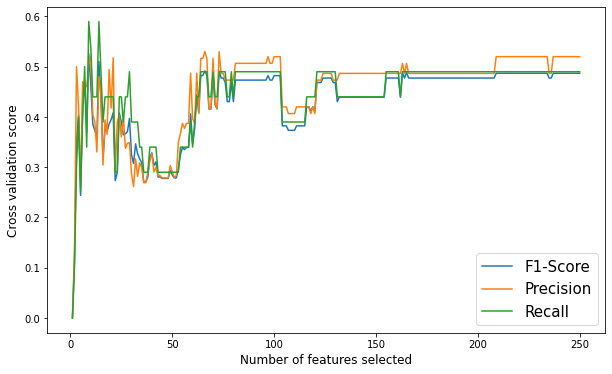

In [47]:
plt.figure(figsize=(10,6))

for n,rfecv in zip(names,rfecvs):
    # Plot number of features VS. cross-validation scores
    plt.xlabel("Number of features selected", fontsize=12)
    plt.ylabel("Cross validation score", fontsize=12)
    plt.plot(range(min_features_to_select,len(rfecv.grid_scores_) + min_features_to_select),
             rfecv.grid_scores_, label=n)

plt.legend(fontsize=15)
plt.show()

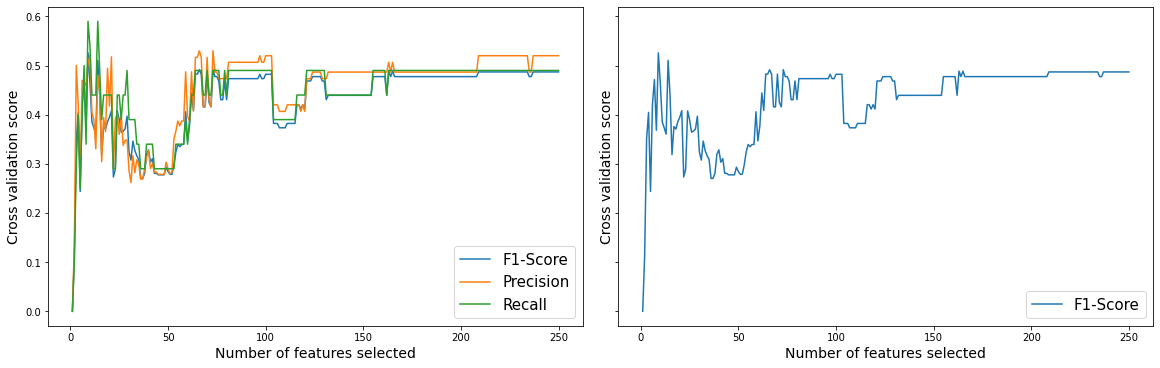

In [54]:
fig, axes = plt.subplots(1,2, figsize=(16, 5), sharey=True, constrained_layout=True)
axes = axes.flatten()
#fig.suptitle("", fontsize=16)

for n,rfecv in zip(names,rfecvs):
    # Plot number of features VS. cross-validation scores
    axes[0].set_xlabel("Number of features selected", fontsize=14)
    axes[0].set_ylabel("Cross validation score", fontsize=14)
    axes[0].plot(range(min_features_to_select,len(rfecv.grid_scores_) + min_features_to_select),
             rfecv.grid_scores_, label=n)

axes[0].legend(fontsize=15)


for n,rfecv in zip(names,rfecvs):
    # Plot number of features VS. cross-validation scores
    axes[1].set_xlabel("Number of features selected", fontsize=14)
    axes[1].set_ylabel("Cross validation score", fontsize=14)
    axes[1].plot(range(min_features_to_select,len(rfecv.grid_scores_) + min_features_to_select),
             rfecv.grid_scores_, label=n)
    break

axes[1].legend(fontsize=15, loc="lower right")



plt.show()

<ipython-input-52-02fcad050829>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["type"] = "NA"
/home/andre/anaconda3/envs/tese/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


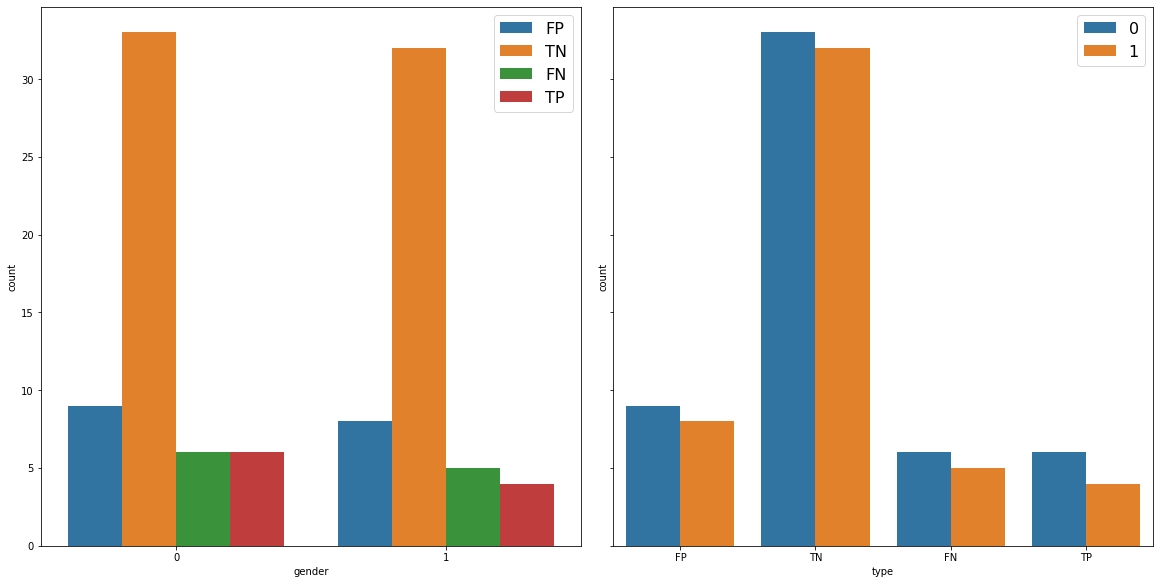

In [52]:
d = {"0": {"Dummy": ["GSM3860560", "GSM3860563", "GSM3860571", "GSM3860574", "GSM3860575", "GSM3860578", "GSM3860559", "GSM3860562", "GSM3860568", "GSM3860572", "GSM3860573", "GSM3860574", "GSM3860560", "GSM3860561", "GSM3860563", "GSM3860570", "GSM3860573", "GSM3860576", "GSM3860563", "GSM3860564", "GSM3860566", "GSM3860569", "GSM3860572", "GSM3860579", "GSM3860560", "GSM3860562", "GSM3860571", "GSM3860573", "GSM3860575", "GSM3860577", "GSM3860559", "GSM3860561", "GSM3860565", "GSM3860568", "GSM3860570", "GSM3860572", "GSM3860562", "GSM3860563", "GSM3860572", "GSM3860575", "GSM3860577", "GSM3860578", "GSM3860563", "GSM3860564", "GSM3860566", "GSM3860567", "GSM3860571", "GSM3860575", "GSM3860560", "GSM3860566", "GSM3860570", "GSM3860573", "GSM3860575", "GSM3860576", "GSM3860560", "GSM3860562", "GSM3860564", "GSM3860571", "GSM3860573", "GSM3860578"], "GaussianNB": ["GSM3860476", "GSM3860480", "GSM3860491", "GSM3860575", "GSM3860557", "GSM3860559", "GSM3860562", "GSM3860568", "GSM3860572", "GSM3860487", "GSM3860491", "GSM3860511", "GSM3860516", "GSM3860527", "GSM3860536", "GSM3860545", "GSM3860552", "GSM3860520", "GSM3860536", "GSM3860557", "GSM3860558", "GSM3860564", "GSM3860566", "GSM3860480", "GSM3860509", "GSM3860519", "GSM3860556", "GSM3860558", "GSM3860562", "GSM3860575", "GSM3860577", "GSM3860487", "GSM3860519", "GSM3860559", "GSM3860561", "GSM3860568", "GSM3860572", "GSM3860519", "GSM3860562", "GSM3860572", "GSM3860575", "GSM3860577", "GSM3860532", "GSM3860564", "GSM3860566", "GSM3860567", "GSM3860575", "GSM3860519", "GSM3860527", "GSM3860557", "GSM3860566", "GSM3860575", "GSM3860560", "GSM3860562", "GSM3860564"], "KNeighbors": ["GSM3860505", "GSM3860526", "GSM3860558", "GSM3860560", "GSM3860571", "GSM3860574", "GSM3860575", "GSM3860525", "GSM3860559", "GSM3860562", "GSM3860568", "GSM3860572", "GSM3860573", "GSM3860574", "GSM3860560", "GSM3860561", "GSM3860570", "GSM3860558", "GSM3860564", "GSM3860566", "GSM3860569", "GSM3860572", "GSM3860505", "GSM3860558", "GSM3860560", "GSM3860562", "GSM3860571", "GSM3860573", "GSM3860575", "GSM3860577", "GSM3860529", "GSM3860559", "GSM3860561", "GSM3860568", "GSM3860572", "GSM3860526", "GSM3860558", "GSM3860562", "GSM3860572", "GSM3860575", "GSM3860577", "GSM3860526", "GSM3860564", "GSM3860566", "GSM3860567", "GSM3860575", "GSM3860505", "GSM3860560", "GSM3860566", "GSM3860570", "GSM3860575", "GSM3860529", "GSM3860560", "GSM3860562", "GSM3860564", "GSM3860571", "GSM3860573"], "SVC": ["GSM3860560", "GSM3860571", "GSM3860574", "GSM3860575", "GSM3860578", "GSM3860559", "GSM3860562", "GSM3860568", "GSM3860572", "GSM3860573", "GSM3860574", "GSM3860560", "GSM3860561", "GSM3860563", "GSM3860570", "GSM3860573", "GSM3860576", "GSM3860563", "GSM3860564", "GSM3860566", "GSM3860569", "GSM3860572", "GSM3860579", "GSM3860505", "GSM3860560", "GSM3860562", "GSM3860571", "GSM3860573", "GSM3860575", "GSM3860577", "GSM3860559", "GSM3860561", "GSM3860568", "GSM3860570", "GSM3860572", "GSM3860562", "GSM3860572", "GSM3860575", "GSM3860577", "GSM3860578", "GSM3860564", "GSM3860566", "GSM3860567", "GSM3860571", "GSM3860575", "GSM3860560", "GSM3860566", "GSM3860570", "GSM3860573", "GSM3860575", "GSM3860576", "GSM3860560", "GSM3860562", "GSM3860564", "GSM3860571", "GSM3860573", "GSM3860578"], "DecisionTree": ["GSM3860480", "GSM3860483", "GSM3860505", "GSM3860539", "GSM3860544", "GSM3860557", "GSM3860560", "GSM3860575", "GSM3860483", "GSM3860488", "GSM3860490", "GSM3860499", "GSM3860505", "GSM3860559", "GSM3860568", "GSM3860572", "GSM3860573", "GSM3860574", "GSM3860560", "GSM3860570", "GSM3860573", "GSM3860480", "GSM3860509", "GSM3860520", "GSM3860564", "GSM3860572", "GSM3860505", "GSM3860519", "GSM3860542", "GSM3860544", "GSM3860556", "GSM3860558", "GSM3860560", "GSM3860562", "GSM3860573", "GSM3860575", "GSM3860577", "GSM3860509", "GSM3860519", "GSM3860556", "GSM3860559", "GSM3860561", "GSM3860568", "GSM3860570", "GSM3860572", "GSM3860483", "GSM3860520", "GSM3860537", "GSM3860551", "GSM3860558", "GSM3860562", "GSM3860575", "GSM3860577", "GSM3860477", "GSM3860517", "GSM3860520", "GSM3860526", "GSM3860537", "GSM3860542", "GSM3860564", "GSM3860571", "GSM3860575", "GSM3860502", "GSM3860560", "GSM3860570", "GSM3860575", "GSM3860479", "GSM3860488", "GSM3860529", "GSM3860532", "GSM3860562", "GSM3860564", "GSM3860571", "GSM3860573"], "RandomForest": ["GSM3860480", "GSM3860560", "GSM3860571", "GSM3860575", "GSM3860559", "GSM3860562", "GSM3860568", "GSM3860572", "GSM3860573", "GSM3860560", "GSM3860561", "GSM3860570", "GSM3860564", "GSM3860480", "GSM3860505", "GSM3860556", "GSM3860558", "GSM3860560", "GSM3860562", "GSM3860573", "GSM3860575", "GSM3860577", "GSM3860559", "GSM3860561", "GSM3860568", "GSM3860570", "GSM3860572", "GSM3860558", "GSM3860562", "GSM3860572", "GSM3860575", "GSM3860577", "GSM3860477", "GSM3860517", "GSM3860564", "GSM3860567", "GSM3860571", "GSM3860575", "GSM3860560", "GSM3860570", "GSM3860575", "GSM3860576", "GSM3860560", "GSM3860562", "GSM3860564", "GSM3860571"], "XGB": ["GSM3860480", "GSM3860557", "GSM3860560", "GSM3860575", "GSM3860490", "GSM3860499", "GSM3860505", "GSM3860559", "GSM3860562", "GSM3860568", "GSM3860572", "GSM3860573", "GSM3860560", "GSM3860570", "GSM3860576", "GSM3860520", "GSM3860558", "GSM3860564", "GSM3860569", "GSM3860579", "GSM3860480", "GSM3860499", "GSM3860505", "GSM3860519", "GSM3860556", "GSM3860558", "GSM3860560", "GSM3860562", "GSM3860573", "GSM3860575", "GSM3860577", "GSM3860559", "GSM3860561", "GSM3860568", "GSM3860570", "GSM3860572", "GSM3860520", "GSM3860521", "GSM3860558", "GSM3860562", "GSM3860575", "GSM3860577", "GSM3860477", "GSM3860517", "GSM3860520", "GSM3860564", "GSM3860575", "GSM3860557", "GSM3860560", "GSM3860570", "GSM3860575", "GSM3860576", "GSM3860513", "GSM3860529", "GSM3860560", "GSM3860562", "GSM3860564", "GSM3860578"]}}
#fig, axes = plt.subplots(1, 1, figsize=(18, 8))

wp = d["0"]["GaussianNB"]

df = data[ clinic_var + [target]]
df["type"] = "NA"

for row in df.iterrows():
    uid = row[0] in wp
    t = row[1][target] == 1
    if uid and t:
        val = "FN"
    elif uid and not t:
        val = "FP"
    elif not uid and t:
        val = "TP"
    elif not uid and not t:
        val = "TN"
    df.loc[row[0], "type"] = val

    
fig, axes = plt.subplots(4,2, figsize=(16, 8), sharey=True, constrained_layout=True)
axes = axes.flatten()

sns.countplot(x="gender", hue="type", data=df, ax=axes[0])
sns.countplot(x="type", hue="gender", data=df, ax=axes[1])
axes[0].legend(fontsize=16)
axes[1].legend(fontsize=16)

sns.countplot(x="stage", hue="type", data=df, ax=axes[2])
sns.countplot(x="type", hue="stage", data=df, ax=axes[3])
axes[2].legend(fontsize=16)
axes[3].legend(fontsize=16)

# Wrong predicted

In [4]:
with open('files/wrongpred/allwrong.txt', 'r') as f:
    wps = json.load(f)
print(wps)

with open('files/wrongpred/knndtwrong.txt', 'r') as f:
    goodwps = json.load(f)
print(goodwps)

['GSM3860564', 'GSM3860567', 'GSM3860562', 'GSM3860568', 'GSM3860561', 'GSM3860577']
['GSM3860488', 'GSM3860563', 'GSM3860526', 'GSM3860533', 'GSM3860566', 'GSM3860502', 'GSM3860541']


## In discriminative with ANOVA

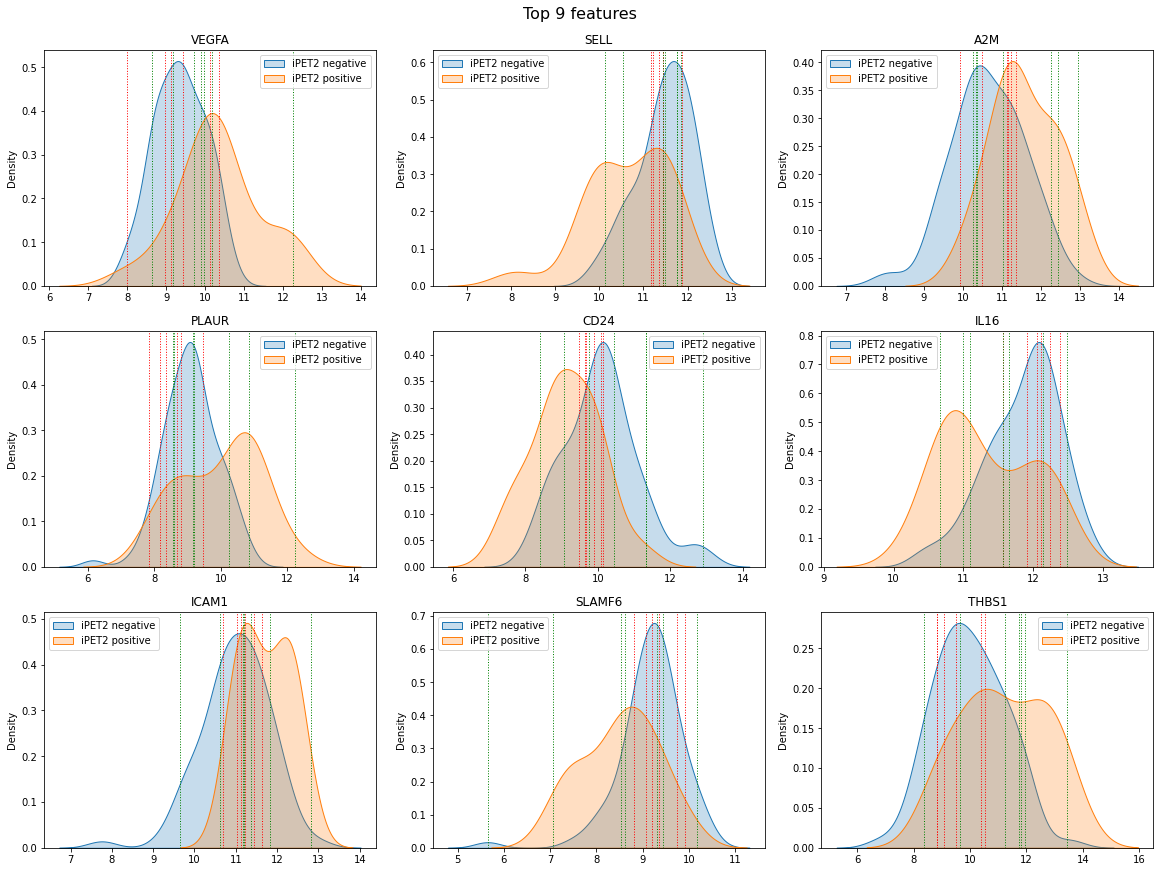

In [65]:
rs = 2345

df = data_union
n = 9
y = df[target].values
X = df.drop(target, axis=1).values

pval = f_classif(X, y)[1]
tops = pval.argsort()[:n]
tops = np.append(tops, df.columns.get_loc(target))
df = df.iloc[:, tops]

fig, axes = plt.subplots(ceil(n/3), 3, figsize=(16, 12), sharey=False, constrained_layout=True)
axes = axes.flatten()
fig.suptitle(f"Top {n} features", fontsize=16)

for i, c in enumerate(df.columns[:-1]):
    pos = df[ df["ipet2"] == 1 ][c]
    neg =  df[ df["ipet2"] == 0 ][c]
    if c in clinic_var:
        sns.countplot(x=target, hue=c, data=df, ax=axes[i])
    else:
        sns.kdeplot(neg, ax=axes[i], fill=True)
        sns.kdeplot(pos, ax=axes[i], fill=True)
        axes[i].legend(("iPET2 negative", "iPET2 positive"), loc="best")
        for wp in wps:
            axes[i].axvline(x=df.loc[wp, c], linewidth=1, color="r", linestyle=":")
        for gwp in goodwps:
            axes[i].axvline(x=df.loc[gwp, c], linewidth=1, color="g", linestyle=":")
    axes[i].set_title(c)
    axes[i].set_xlabel("")
#plt.tight_layout()
#plt.savefig("./images/exploratory/12_discriminative_genes.png")

## In discriminative with MI

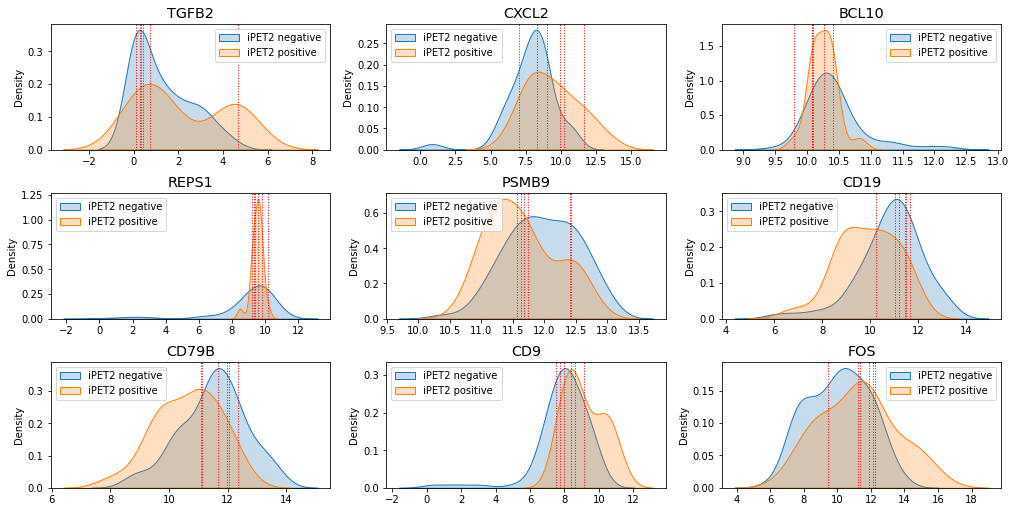

In [20]:
rs = 2345

df = data_union
n = 9
y = df[target].values
X = df.drop(target, axis=1).values

mi = mutual_info_classif(X, y, random_state=rs)
tops = mi.argsort()[::-1][:n]

tops = np.append(tops, df.columns.get_loc(target))
df = df.iloc[:, tops]

fig, axes = plt.subplots(ceil(n/3), 3, figsize=(14, 7), sharey=False, constrained_layout=True)
axes = axes.flatten()
#fig.suptitle(f"Top {n} features", fontsize=16)

for i, c in enumerate(df.columns[:-1]):
    pos = df[ df["ipet2"] == 1 ][c]
    neg =  df[ df["ipet2"] == 0 ][c]
    if c in clinic_var:
        sns.countplot(x=target, hue=c, data=df, ax=axes[i])
    else:
        sns.kdeplot(neg, ax=axes[i], fill=True)
        sns.kdeplot(pos, ax=axes[i], fill=True)
        axes[i].legend(("iPET2 negative", "iPET2 positive"), loc="best", fontsize="medium")
        for wp in wps:
            axes[i].axvline(x=df.loc[wp, c], linewidth=1, color="r", linestyle=":")
        #for gwp in goodwps:
            #axes[i].axvline(x=df.loc[gwp, c], linewidth=1, color="g", linestyle=":")
    axes[i].set_title(c,fontsize="x-large")
    axes[i].set_xlabel("")
plt.savefig("./images/exploratory/discriminative_genes.png", dpi=200)

<ipython-input-6-09500b34e602>:59: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


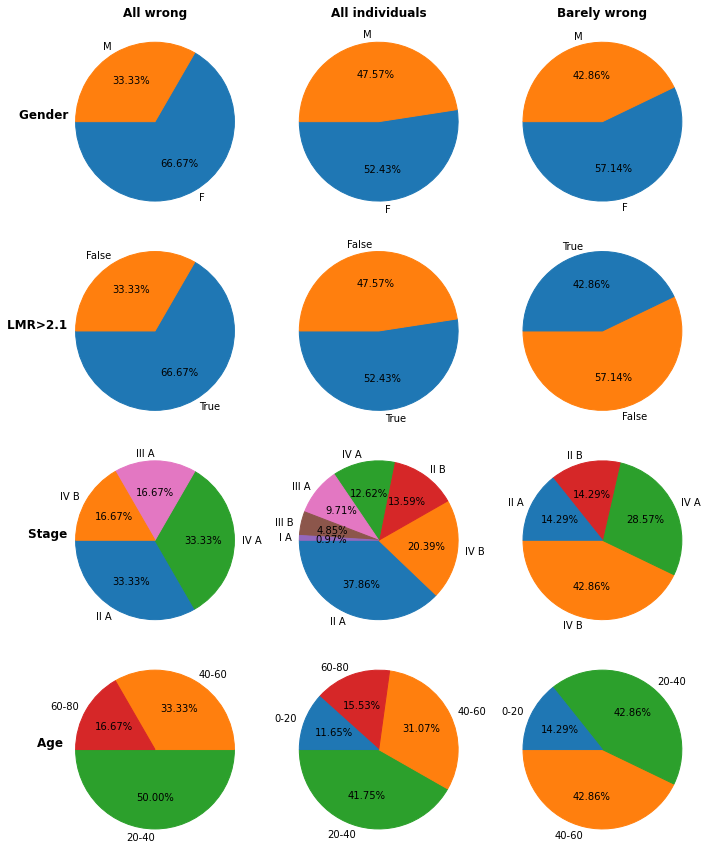

In [6]:
data_wp = data.copy()
data_wp["gender"] = data_wp["gender"].replace({0: "F", 1: "M"})
data_wp["stage"] = data_wp["stage"].replace({1: "I A", 2:"I B", 3:"II A", 4:"II B", 5:"III A", 6:"III B", 7:"IV A", 8:"IV B"})
data_wp["lmr>2.1"] = data_wp["lmr>2.1"].replace({0: "False", 1: "True"})


data_wp.loc[ data_wp["age"]>0, "age_c" ] = "0-20"
data_wp.loc[ data_wp["age"]>20, "age_c" ] = "20-40"
data_wp.loc[ data_wp["age"]>40, "age_c" ] = "40-60"
data_wp.loc[ data_wp["age"]>60, "age_c" ] = "60-80"
data_wp.loc[ data_wp["age"]>80, "age_c" ] = "80+"
data_wp["age"] = data_wp["age_c"]

fig, axes = plt.subplots(4, 3, figsize=(10, 12), sharey=False)

for i,cl in enumerate(["gender", "lmr>2.1", "stage","age"]):
    
    #generate color dict
    colors = ['tab:blue','tab:orange','tab:green','tab:red',"tab:purple", "tab:brown", "tab:pink"]
    vals = data_wp[cl].unique()
    color_dict = dict(zip(vals, colors))
    
    #wp
    counts = data_wp.loc[wps, cl].value_counts()
    v = counts.values
    k = counts.keys().tolist()
    patches, texts, _ = axes[i][0].pie(v, labels = k, autopct='%1.2f%%',startangle=180)
    for p,t in zip(patches,texts):
        p.set_color(color_dict[t.get_text()])
    
    #all
    counts = data_wp.loc[:, cl].value_counts()
    v = counts.values
    k = counts.keys().tolist()
    patches, texts, _  = axes[i][1].pie(v, labels = k, autopct='%1.2f%%',startangle=180)
    for p,t in zip(patches,texts):
        p.set_color(color_dict[t.get_text()])
        
    #good wp
    counts = data_wp.loc[goodwps, cl].value_counts()
    v = counts.values
    k = counts.keys().tolist()
    patches, texts, _ = axes[i][2].pie(v, labels = k, autopct='%1.2f%%',startangle=180)
    for p,t in zip(patches,texts):
        p.set_color(color_dict[t.get_text()])
    

cols = ["All wrong", "All individuals",  "Barely wrong"]
#rows = ["Gender    ", "Age ", "Stage  ", "LMR>2.1       "]
rows = ["Gender    ", "LMR>2.1       ",  "Stage  ", "Age "]

for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontweight="bold")

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large', fontweight="bold", ha="center")
    
fig.tight_layout()
fig.show()
